<a href="https://colab.research.google.com/github/valesierrai/Analisis-Supervisado-para-el-AD/blob/main/Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo Final**

Base de datos recuperada de *Kaggle*: https://www.kaggle.com/datasets/mahnazarjmand/country-data

In [ ]:
#Cargamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Cargamos la base de datos
df = pd.read_csv('/content/Country-data.csv')
# Fijamos como índice el nombre del país (como identificador único)
df.set_index('country', inplace=True)
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
#Revisamos la información de la base de datos, en busca de datos faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [ ]:
#Creamos una columna en donde me diga si el país suele importar o exportar más
df['flow'] = np.where(df['exports'] > df['imports'], 'Export', 'Import')

#Cambiamos de esta columna 'Export' por '0' e 'Import' por '1'
df['flow'] = np.where(df['flow'] == 'Export', 0, 1)

#Revisamos
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,flow
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


En la columna 'flow':

Export = 0

Import= 1

Para tener un punto de comparación, vamos a entrenar **2 modelos de clasificación**, uno lineal y uno de árbol.

###**Clasificador Lineal**

In [ ]:
#Importamos librerias adicioanles
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Eliminamos registros con NA
df_dropna = df.dropna()
# La variable objetivo será el 'flow'
X = df_dropna.drop(columns=['flow'])
# Separamos las observaciones de las etiquetas
y = df_dropna['flow']
# Hacemos la separación de entranamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
# Verificamos los tamaños de los conjuntos
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (116, 9) (116,)
Test: (51, 9) (51,)


In [ ]:
#Generamos una lista con los nombres de las variables numéricas flotantes
num_vars = ['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer'] # Se definen las variables numéricas
#Instanciamos los codificadores para las variables numéricas enteras
#Usamos 'unknown_value=-1' para que le asigne a los valores faltantes -1 y así prevenir el error
oe_income = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_gdpp = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#Instanciamos el escalador para las variables numéricas
ss = StandardScaler()
#Instanciamos el Preprocesador
preprocessor = ColumnTransformer(transformers = [('oe_income', oe_income, ['income']), # Codificación ordinal para la variable 'income'
                                               ('oe_gdpp', oe_gdpp, ['gdpp']), # Codificación ordinal para la variable 'gdpp'
                                               ('ss', ss, num_vars)], # Prepocesamiento de las variables numéricas
                                               remainder = 'passthrough') # El resto de las columnas se mantienen sin cambios
#Instanciamos el Clasificador
model = LogisticRegression(max_iter = 10000, solver = 'liblinear', class_weight = 'balanced') # Se define el modelo
# Instanciamos el pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('model', model)]) #Organizar un poco mejor el proceso del modelo
# Definimos los hiperparámetros que sintonizaremos en el clasificador
dist = {'model__C':loguniform(1e-3, 1e3), 'model__penalty':['l1', 'l2']}

#Hacemos la búsqueda de hiperparámetros
grid_search = RandomizedSearchCV(estimator = pipe, param_distributions = dist, scoring = 'f1_weighted', cv = 5)
grid_search.fit(X_train, y_train)

#Encontramos el desempeño para el test
test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average = 'weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.932 with {'model__C': 273.85658806388926, 'model__penalty': 'l1'}
Test score: 1.000


Aqui vemos que el mejor puntaje de validación fue de 0.932, y el tipo de regularización que se aplicará será Lasso (L1), pues este es el que funciona mejor para el modelo en este caso.

Asimismo, vemos que si bien el puntaje de test es 1, y es sobreajuste, por el tipo de datos del modelo como tal, tiene sentido que el resultado sea de esta manera.

In [ ]:
#Imprimimos el reporte de clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        32

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



Como lo refleja el reporte de clasificación y en la matriz de confusión, el modelo pudó perfectamente clasificar el tipo de exportaciones e importaciones. Pero, como se explicó anteriormente tiene sentido por el tipo de datos que se están utilizando, como por el hecho de que dentro de los mismos datos cuento con variables como 'exports' e 'imports'.

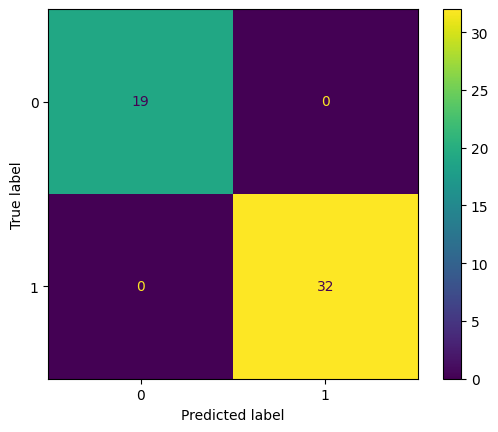

In [ ]:
#Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

En este caso la matriz nos muestra el escenario ideal de la predicción para los datos escogidos.

###**Árbol de Decisión**

In [ ]:
#Importamos librerias adicionales
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Procedemos igual al caso del clasificador lineal
X = df.drop(columns=['flow'])
y = df['flow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (116, 9) (116,)
Test: (51, 9) (51,)


In [ ]:
#Hacemos poda con ccp_alpha
dist = {'ccp_alpha':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = dist, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.735 with {'ccp_alpha': 0.020527070113624125}
Test score: 0.762


Para este caso, el mejor puntaje de validación fue de 0.73 con un ccp_alpha de 0.02. De la misma forma, obtuvimos un resultado de prueba de 0.76, el cual es bueno, y podríamos decir que el 'ccp_alpha' nos ayudó a evitar el overfitting para este modelo.

In [ ]:
#Imprimimos el Reporte de Clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        19
           1       0.79      0.84      0.82        32

    accuracy                           0.76        51
   macro avg       0.75      0.74      0.74        51
weighted avg       0.76      0.76      0.76        51



En este caso, notamos que el modelo tuvo una precisión del 71% en predecir los 0 (Exportaciones), y un 79% en predecir los 1 (Importaciones). Como estos valores estar relativamente cercanos, el modelo pudo establecer buenas predicciones y arrojar buenos resultados de ambas categorías. Asimismo, con la columna 'support' podemos ver que no hay desbalanceo entre las muestras de cada clase, ya que los datos están relativamente cerca entre sí (19 son exportaciones y 32 importaciones).

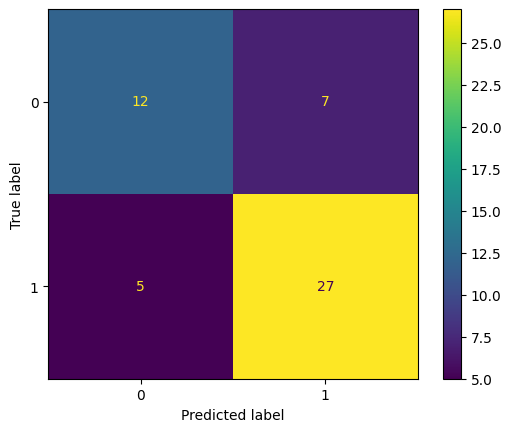

In [ ]:
#Visualizamos la Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Con la matriz de confusión logramos visualizar que 27 de las 32 importaciones las logró clasificar bien (cuadro inferior derecho). Mientras que 5 de estas las clasificó como exportaciones. Algo parecido ocurrió con las exportaciones, ya que clasificó correctamente 12/19 (cuadro superior izquierdo) y el resto (7) se clasificaron como importaciones.

Si bien estos errores fueron bajos para ambos casos, podrían llegar a ser un problema cuando se miren temas de comercio exterior globales, e incluso datos de un país en específico, como lo sería información para realizar una balanza de pagos o simplemente saber si el país tiene un superavit o un deficit.

##**Modelos Bagging**

In [ ]:
#Importamos librerias adicionales
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import loguniform

In [ ]:
# Instanciamos el modelo de ensamble con los árboles como clasificadores. Tendremos 100 árboles
bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(), n_estimators = 100, random_state = 77)
# Entrenamos el modelo
bag_model.fit(X_train, y_train)
train_score = f1_score(y_train, bag_model.predict(X_train), average = 'weighted')
test_score = f1_score(y_test, bag_model.predict(X_test), average = 'weighted')
print(f'Train score: {train_score:.2f}')
print(f'Test score: {test_score:.2f}')

Train score: 1.00
Test score: 0.73


Tenemos un modelo sobreajustado, y por ende tenemos que regularizarlo

In [ ]:
#Vamos a regularizar limitando la profundidad y sintonizando los estimadores
bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(ccp_alpha = 0.01)) #Bajar el overfitting del árbol (ccp_alpha)
dist = {'n_estimators':range(1, 201)}
grid_search = RandomizedSearchCV(estimator = bag_model, param_distributions = dist, cv = 5, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

#Mostramos los Resultados
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.82 with {'n_estimators': 7}
Test score: 0.82


In [ ]:
#Imprimimos el Reporte de Clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.81      0.94      0.87        32

    accuracy                           0.82        51
   macro avg       0.83      0.78      0.80        51
weighted avg       0.83      0.82      0.82        51



En comparación al modelo anterior notamos que existe una mejora solamente en temas de la precisión, ya que para este modelo obtenemos una precisión de 0.86 para exportaciones y 0.81 para importaciones.

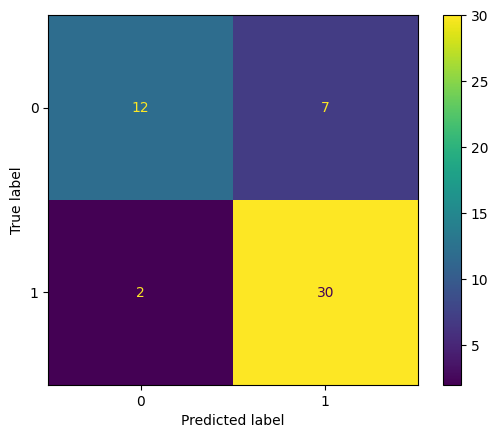

In [ ]:
#Visualizamos la Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Con la matriz de confusión vemos que con respecto al modelo anterior, este mejora en la clasificación de importaciones. Puesto que clasificó correctamente 30/32 y en el modelo anterior solo clasificó 27/32. No obstante, en la predicción de las exportaciones con respecto al modelo anterior notamos que permanece exactamente igual (12/19).

##**Random Forest**

In [ ]:
#Importamos librerias adicionales
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform

In [ ]:
rf_model = RandomForestClassifier(random_state=77)
dist = {'n_estimators':range(1, 201), 'ccp_alpha':loguniform(1e-4, 1e2)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

In [ ]:
#Instanciamos el modelo
rf_model = RandomForestClassifier(random_state=77)

#Definimos los hiperparámetros
dist = {'n_estimators':range(1, 201), 'ccp_alpha':loguniform(1e-4, 1e2),'max_depth':range(2,10), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

#Hacemos la búsqueda de hiperparámetros
test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')

#Encontramos el desempeño para test
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.77 with {'ccp_alpha': 0.00276319195134762, 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 118}
Test score: 0.78


In [ ]:
#Imprimimos el Reporte de Clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.53      0.65        19
           1       0.77      0.94      0.85        32

    accuracy                           0.78        51
   macro avg       0.80      0.73      0.75        51
weighted avg       0.79      0.78      0.77        51



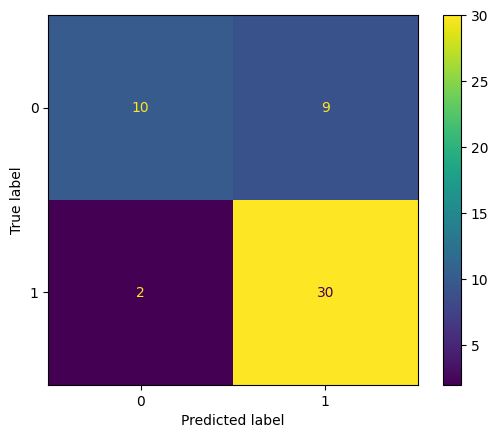

In [ ]:
#Visualizamos la Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

In [ ]:
#Creamos una tabla para visualizar la importancia de las variables
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
rf_features.sort_values('Importance', ascending=False)

,Feature,Importance
1,exports,0.190684
4,income,0.141335
3,imports,0.136730
8,gdpp,0.130152
5,inflation,0.116527
6,life_expec,0.077551
7,total_fer,0.074484
2,health,0.068633
0,child_mort,0.063905


##**Gradient Boosting**

In [ ]:
#Librerias Adicionales
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from scipy.stats import uniform

In [ ]:
#Eliminamos registros con NA
df_dropna = df.dropna()
#La variable objetivo será el 'flow'
X = df_dropna.drop(columns=['flow'])
#Separamos las observaciones de las etiquetas
y = df_dropna['flow']
#Hacemos la separación de entranamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
#Verificamos los tamaños de los conjuntos
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (116, 9) (116,)
Test: (51, 9) (51,)


In [ ]:
#Instanciamos el modelo
gb_model = GradientBoostingClassifier(n_iter_no_change=5)

#Definimos los hiperparámetros. Changed 'squared_error' to 'log_loss'
dist = {'n_estimators':range(1, 201), 'max_depth':range(1,10), 'learning_rate':uniform(0,1), 'min_samples_split':range(2,5), 'loss': ['log_loss']}
grid_search = RandomizedSearchCV(estimator=gb_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

#Hacemos la búsqueda de hiperparámetros
test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')

#Imprimimos los resultados
print(f'Best score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best score: 0.808 with {'learning_rate': 0.33574626121053397, 'loss': 'log_loss', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 192}
Test score: 0.776


In [ ]:
#Imprimimos el Reporte de Clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67        19
           1       0.78      0.91      0.84        32

    accuracy                           0.78        51
   macro avg       0.78      0.74      0.75        51
weighted avg       0.78      0.78      0.78        51



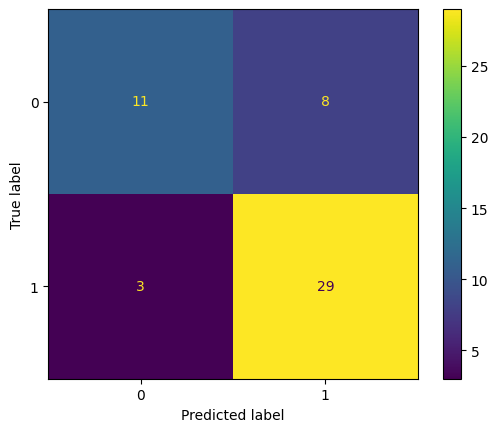

In [ ]:
#Visualizamos la Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

In [ ]:
#Creamos una tabla para visualizar la importancia de las variables
gb_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
gb_features.sort_values('Importance', ascending=False)

,Feature,Importance
1,exports,0.297589
3,imports,0.240136
5,inflation,0.104760
6,life_expec,0.088433
0,child_mort,0.088296
2,health,0.076198
7,total_fer,0.042533
4,income,0.035560
8,gdpp,0.026496


##**Análisis de Resultados**